In [ ]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd
import pymc as pm
import sys
import arviz as az
import pytensor.tensor as at


# 将所有输出重定向到文件
#sys.stdout = open('all_output.txt', 'w')

# 加载数据,绘制直方图
df = pd.read_csv('/lustre/home/hangqian/projects/data/zircons/Roberts_Spencer_2015.csv')
years = df["U-Pb (Ma)"]
data = plt.hist(years, bins=200)
zircons_data = data[0]
ages = data[1][1:]


data = plt.hist(years, bins=200)
plt.xlabel('Ages (Ma)')
plt.ylabel('Frequency')
plt.title('Histogram of Zircon Ages')
plt.grid(True)

# 保存直方图到本地
plt.savefig('histogram.png')

# 绘制散点图
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages")

# 保存散点图到本地
plt.savefig('scatter_plot.png')

#定义变换方法
tr =pm.distributions.transforms

Order = tr.Ordered()

#使用PyMC建立模型
with pm.Model() as model:
    
    k_values = list(range(2,6))
    rates_list = [] #用于存储rates随机变量的列表
    switchpoints_list = [] # 用于存储switchpoints随机变量的列表

    for k in k_values:
        #将所有k取值的rates和switchpoints添进列表
        rates_list.append(pm.Exponential(f'rates_{k}', 1.0, shape=k + 1))
        switchpoints_list.append(pm.Uniform(f'switchpoints_{k}', lower=0, upper=max(ages), shape=k, transform=Order, initval=np.linspace(0, max(ages), k)))
    #将列表转化为pm类型的列表
    meta_rates = at.as_tensor(rates_list)
    meta_switchpoints = at.as_tensor(switchpoints_list)

    index = pm.DiscreteUniform(name = "index",lower = 0, upper = 6-2-1)
    rates = meta_rates[index]
    switchpoints = meta_switchpoints[index]
    #rates = rates_list[index]
    #switchpoints = switchpoints_list[index]
    
    rate = rates[0]
    for i in range(6-2):
        if pm.math.gt(i, index-1):
            break
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i + 1])
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    trace = pm.sample(tune=1000, cores=1)

# 输出 trace 绘图到文件
az.plot_trace(trace)
plt.savefig('trace_plot.png')

# 输出 summary 结果到文件
summary = pm.summary(trace)
with open('summary.txt', 'w') as f:
    f.write(str(summary))

# 关闭重定向，恢复标准输出
#sys.stdout.close()
#sys.stdout = sys.__stdout__

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [rate_2, rate_3, rate_4, switchpoint_2, switchpoint_3, switchpoint_4]
>Metropolis: [index]


IndexError: index out of bounds
Apply node that caused the error: Subtensor{i, j}(Join.0, ScalarFromTensor.0, 0)
Toposort index: 9
Inputs types: [TensorType(float64, shape=(3, 5)), ScalarType(int64), ScalarType(uint8)]
Inputs shapes: [(3, 5), (), ()]
Inputs strides: [(40, 8), (), ()]
Inputs values: ['not shown', 3, 0]
Outputs clients: [[ExpandDims{axis=0}(Subtensor{i, j}.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/sampling/mcmc.py", line 653, in sample
    step = assign_step_methods(model, step, methods=pm.STEP_METHODS, step_kwargs=kwargs)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/sampling/mcmc.py", line 233, in assign_step_methods
    return instantiate_steppers(model, steps, selected_steps, step_kwargs)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/sampling/mcmc.py", line 134, in instantiate_steppers
    step = step_class(vars=vars, model=model, **args)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/step_methods/metropolis.py", line 225, in __init__
    self.delta_logp = delta_logp(initial_values, model.logp(), vars, shared)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/model.py", line 718, in logp
    rv_logps = transformed_conditional_logp(
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/logprob/basic.py", line 612, in transformed_conditional_logp
    temp_logp_terms = conditional_logp(
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/logprob/basic.py", line 477, in conditional_logp
    fgraph, rv_values, _ = construct_ir_fgraph(rv_values, ir_rewriter=ir_rewriter)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/logprob/rewriting.py", line 465, in construct_ir_fgraph
    ir_rewriter.rewrite(fgraph)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
    result = self._run_cell(
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_5160/2517855913.py", line 77, in <module>
    rate = rates[0]
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
    result = self._run_cell(
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_5160/2517855913.py", line 71, in <module>
    rates = meta_rates[index]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

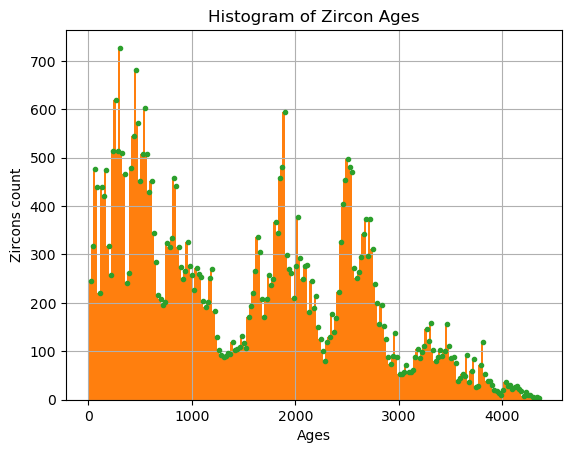

In [12]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd
import pymc as pm
import sys
import arviz as az
import pytensor.tensor as at


# 将所有输出重定向到文件
#sys.stdout = open('all_output.txt', 'w')

# 加载数据,绘制直方图
df = pd.read_csv('/lustre/home/hangqian/projects/data/zircons/Roberts_Spencer_2015.csv')
years = df["U-Pb (Ma)"]
data = plt.hist(years, bins=200)
zircons_data = data[0]
ages = data[1][1:]


data = plt.hist(years, bins=200)
plt.xlabel('Ages (Ma)')
plt.ylabel('Frequency')
plt.title('Histogram of Zircon Ages')
plt.grid(True)

# 保存直方图到本地
plt.savefig('histogram.png')

# 绘制散点图
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages")

# 保存散点图到本地
plt.savefig('scatter_plot.png')

#定义变换方法
tr =pm.distributions.transforms

Order = tr.Ordered()

#使用PyMC建立模型
with pm.Model() as model:
    
    #本例中，拐点个数k取值范围为2-4，故meta_rate的shape是(4-2+1, 4+1), meta_switchpoints的shape是(4-2+1,4)
    rate_2 = pm.Exponential('rate_2', 1.0, shape=5)
    rate_3 = pm.Exponential('rate_3', 1.0, shape=5)
    rate_4 = pm.Exponential('rate_4', 1.0, shape=5)

    switchpoint_2 = pm.Uniform('switchpoint_2', lower=0, upper=max(ages), shape=4, transform=Order, initval=np.linspace(0, max(ages), 4))
    switchpoint_3 = pm.Uniform('switchpoint_3', lower=0, upper=max(ages), shape=4, transform=Order, initval=np.linspace(0, max(ages), 4))
    switchpoint_4 = pm.Uniform('switchpoint_4', lower=0, upper=max(ages), shape=4, transform=Order, initval=np.linspace(0, max(ages), 4))

    
    
    meta_rates = at.stack([rate_2,rate_3,rate_4])
    meta_switchpoints = at.stack([switchpoint_2,switchpoint_3,switchpoint_4])

    #index取值范围是0-2，对应拐点数K的2-4，从0开始是为了方便作为索引取值
    index = pm.DiscreteUniform(name = "index",lower = 0, upper = 2)

    #第一次索引，代表“拐点个数”的随机性
    rates = meta_rates[index]
    switchpoints = meta_switchpoints[index]
    #rates = rates_list[index]
    #switchpoints = switchpoints_list[index]

    #第二次索引，代表拐点间强度的随机性
    rate = rates[0]
    for i in range(3):
        if pm.math.gt(i, index):
            break
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i + 1])
    
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    trace = pm.sample(tune=1000, cores=1)

# 输出 trace 绘图到文件
az.plot_trace(trace)
plt.savefig('trace_plot.png')

# 输出 summary 结果到文件
summary = pm.summary(trace)
with open('summary.txt', 'w') as f:
    f.write(str(summary))

# 关闭重定向，恢复标准输出
#sys.stdout.close()
#sys.stdout = sys.__stdout__

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [rate_2, rate_3, switchpoint_2, switchpoint_3]
>Metropolis: [index]


IndexError: index out of bounds
Apply node that caused the error: Subtensor{i, j}(Join.0, ScalarFromTensor.0, 0)
Toposort index: 7
Inputs types: [TensorType(float64, shape=(2, 4)), ScalarType(int64), ScalarType(uint8)]
Inputs shapes: [(2, 4), (), ()]
Inputs strides: [(32, 8), (), ()]
Inputs values: ['not shown', 2, 0]
Outputs clients: [[ExpandDims{axis=0}(Subtensor{i, j}.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/sampling/mcmc.py", line 653, in sample
    step = assign_step_methods(model, step, methods=pm.STEP_METHODS, step_kwargs=kwargs)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/sampling/mcmc.py", line 233, in assign_step_methods
    return instantiate_steppers(model, steps, selected_steps, step_kwargs)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/sampling/mcmc.py", line 134, in instantiate_steppers
    step = step_class(vars=vars, model=model, **args)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/step_methods/metropolis.py", line 225, in __init__
    self.delta_logp = delta_logp(initial_values, model.logp(), vars, shared)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/model.py", line 718, in logp
    rv_logps = transformed_conditional_logp(
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/logprob/basic.py", line 612, in transformed_conditional_logp
    temp_logp_terms = conditional_logp(
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/logprob/basic.py", line 477, in conditional_logp
    fgraph, rv_values, _ = construct_ir_fgraph(rv_values, ir_rewriter=ir_rewriter)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/pymc/logprob/rewriting.py", line 465, in construct_ir_fgraph
    ir_rewriter.rewrite(fgraph)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
    result = self._run_cell(
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_5160/3746168611.py", line 75, in <module>
    rate = rates[0]
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
    result = self._run_cell(
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_5160/3746168611.py", line 69, in <module>
    rates = meta_rates[index]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

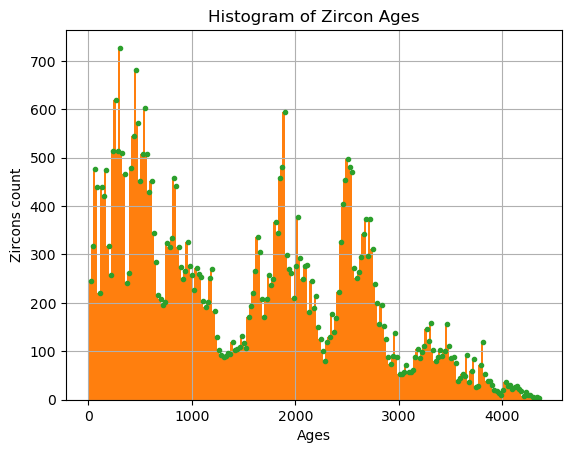

In [14]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd
import pymc as pm
import sys
import arviz as az
import pytensor.tensor as at


# 将所有输出重定向到文件
#sys.stdout = open('all_output.txt', 'w')

# 加载数据,绘制直方图
df = pd.read_csv('/lustre/home/hangqian/projects/data/zircons/Roberts_Spencer_2015.csv')
years = df["U-Pb (Ma)"]
data = plt.hist(years, bins=200)
zircons_data = data[0]
ages = data[1][1:]


data = plt.hist(years, bins=200)
plt.xlabel('Ages (Ma)')
plt.ylabel('Frequency')
plt.title('Histogram of Zircon Ages')
plt.grid(True)

# 保存直方图到本地
plt.savefig('histogram.png')

# 绘制散点图
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages")

# 保存散点图到本地
plt.savefig('scatter_plot.png')

#定义变换方法
tr =pm.distributions.transforms

Order = tr.Ordered()

#使用PyMC建立模型
with pm.Model() as model:
    
    #本例中，拐点个数k取值范围为2-3，故meta_rate的shape是(3-2+1, 3+1), meta_switchpoints的shape是(3-2+1,3)
    rate_2 = pm.Exponential('rate_2', 1.0, shape=4)
    rate_3 = pm.Exponential('rate_3', 1.0, shape=4)

    switchpoint_2 = pm.Uniform('switchpoint_2', lower=0, upper=max(ages), shape=3, transform=Order, initval=np.linspace(100, max(ages)-100, 3))
    switchpoint_3 = pm.Uniform('switchpoint_3', lower=0, upper=max(ages), shape=3, transform=Order, initval=np.linspace(100, max(ages)-100, 3))

    
    
    meta_rates = at.stack([rate_2,rate_3])
    meta_switchpoints = at.stack([switchpoint_2,switchpoint_3])

    #index取值范围是0-1，对应拐点数K的2-3，从0开始是为了方便作为索引取值
    index = pm.DiscreteUniform(name = "index",lower = 0, upper = 1)

    #第一次索引，代表“拐点个数”的随机性
    rates = meta_rates[index]
    switchpoints = meta_switchpoints[index]
    #rates = rates_list[index]
    #switchpoints = switchpoints_list[index]

    #第二次索引，代表拐点间强度的随机性
    rate = rates[0]
    for i in range(2):
        if pm.math.gt(i, index):
            break
        rate = pm.math.switch(switchpoints[i] >= ages, rate, rates[i + 1])
    
    disasters = pm.Poisson("counts", rate, observed=zircons_data)
    
    trace = pm.sample(tune=1000, cores=1)

# 输出 trace 绘图到文件
az.plot_trace(trace)
plt.savefig('trace_plot.png')

# 输出 summary 结果到文件
summary = pm.summary(trace)
with open('summary.txt', 'w') as f:
    f.write(str(summary))

# 关闭重定向，恢复标准输出
#sys.stdout.close()
#sys.stdout = sys.__stdout__